# What are the most demanded skills for the top 3 most popular data roles in the UK?
### Methodology
1. Clean-up skill column
2. Calculate skill count based on 'job_title_short'
3. Calculate skill percentage
4. Plot final findings

In [1]:
# Importing libraries
import ast
import matplotlib.pyplot as plt
import pandas as pd
from datasets import load_dataset
import seaborn as sns

# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x) # convert skill_list from str to list

In [2]:
# only select data from the UK
df_uk = df[df['job_country'] == 'United Kingdom']

In [3]:
# explode the 'job_skills' column into separate rows per skill
df_skills = df_uk.explode('job_skills')

In [4]:
# group all the rows of skills into their associated 'job_title_short', using .size() agg
df_skills_count = df_skills.groupby(['job_skills', 'job_title_short']).size()

# this is now a series, but I want to convert to a data frame. Hence, reset the index.
df_skills_count = df_skills_count.reset_index(name='skill_count')

#sort by 'skill_count' for plotting later. make ascending=False so most populated are at the top, inplace=True so it overwrites
df_skills_count.sort_values(by='skill_count', ascending=False, inplace=True)

In [5]:
# find the most populated jobs. start by finding the unique values and converting to a list
job_titles = df_skills_count['job_title_short'].unique().tolist()

# slice the list for the last 3 unique roles, which will be the most populated, also sort alphabetically
job_titles = sorted(job_titles[:3])

job_titles

['Data Analyst', 'Data Engineer', 'Data Scientist']

## Producing the first plot

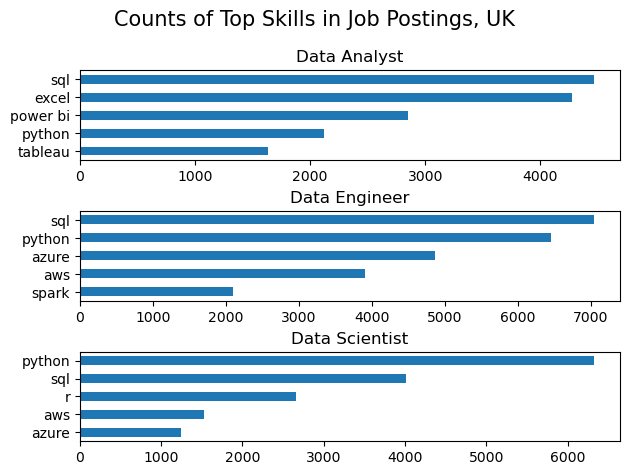

In [6]:
# create a set of axes that has the dimensions of as many specified job_titles, by 1
fig, ax = plt.subplots(len(job_titles), 1)

# use a for loop to extract the index and job_title for the enumerated job_titles list
for i, job_title in enumerate(job_titles):

    # define the data frame to plot, filtering by the 'job_title_short' column's top 5 values
    df_plot = df_skills_count[df_skills_count['job_title_short'] == job_title].head(5)

    # plot using a horizontal bar chart, each chart using their index(i) and associated 'job_title'
    df_plot.plot(kind="barh", x='job_skills', y='skill_count', ax=ax[i], title=job_title)

    # perform some cleanup for visual clarity
    ax[i].invert_yaxis() # ensures highest skill count is at the top of each plot
    ax[i].set_ylabel('') # no y label is necessary
    ax[i].legend().set_visible(False) # legend is not necessary

fig.suptitle('Counts of Top Skills in Job Postings, UK', fontsize=15)
fig.tight_layout(h_pad=.5) # fix the overlap, using a specified horizontal padding
plt.show()

## Converting count to percentage

In [7]:
# make a new dataframe that includes a column of the 'jobs_total' by summing the count of 'job_title_shorts', and converting from a series to df
df_job_title_count = df_uk['job_title_short'].value_counts().reset_index(name='jobs_total')

In [8]:
# merge the data frame created to our df, using left merging and joining on the 'job_title_short' column
df_skills_percent = pd.merge(df_skills_count, df_job_title_count, how='left', on='job_title_short')

# find the percentage that a certain skill is in the total job postings, using a simple equation
df_skills_percent['skills_percent'] = 100 *  (df_skills_percent['skill_count'] / df_skills_percent['jobs_total'])

df_skills_percent

,job_skills,job_title_short,skill_count,jobs_total,skills_percent
0,sql,Data Engineer,7050,11807,59.710341
1,python,Data Engineer,6462,11807,54.730245
2,python,Data Scientist,6329,9148,69.184521
3,azure,Data Engineer,4865,11807,41.204370
4,sql,Data Analyst,4467,10482,42.615913
...,...,...,...,...,...
1414,openstack,Software Engineer,1,541,0.184843
1415,opencv,Software Engineer,1,541,0.184843
1416,opencv,Machine Learning Engineer,1,317,0.315457
1417,objective-c,Data Analyst,1,10482,0.009540


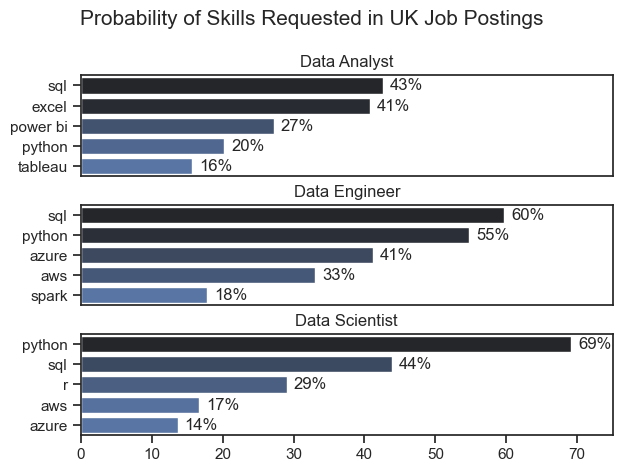

In [10]:
#copy code from above cell, original comments omitted

fig, ax = plt.subplots(len(job_titles), 1)

sns.set_theme(style="ticks")

for i, job_title in enumerate(job_titles):
    # change the dataframe we are working with to 'df_skills_percent'
    df_plot = df_skills_percent[df_skills_percent['job_title_short'] == job_title].head(5)
    # change to plotting with seaborn, for ease of customising
    sns.barplot(data=df_plot, x='skills_percent', y='job_skills', ax=ax[i], hue='skill_count', palette='dark:b_r')

    ax[i].set_title(job_title)
    ax[i].set_ylabel('')  # no need for labels as title and plots are sufficient
    ax[i].set_xlabel('')
    ax[i].get_legend().remove() # remove legend entirely
    ax[i].set_xlim(0, 75) # set x limit so all plots are on same axis

    # loop through to find percentages of each role and add to plot (j is index in this case)
    for j, value in enumerate(df_plot['skills_percent']):
        ax[i].text(value + 1, j, f'{value:.0f}%', va="center") # add text of the value, 'value' + 1 units across on the xaxis, at the jth index, centered
    if i != len(job_titles) - 1: # remove the axes for all but the lowest plot, for cleanup
        ax[i].set_xticks([])

fig.suptitle('Probability of Skills Requested in UK Job Postings', fontsize=15) # title changed to reflect percentages
fig.tight_layout(h_pad=.5) 
plt.show()